## PREPARATION

In [1]:
# Reference: https://stackoverflow.com/questions/15514593/importerror-no-module-named-when-trying-to-run-python-script/15622021#15622021
import sys
sys.path.append(r'S:\Grid_Ori_bigdata')

In [2]:
import os

import numpy as np
import pandas as pd

import rasterio as rio
import xarray as xr
import rioxarray as rxr

import geopandas as gpd

from rasterio.features import shapes

from sklearn.metrics import mean_squared_error

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks") # Ref: https://seaborn.pydata.org/tutorial/aesthetics.html

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # For creating grid spec

In [3]:
main_dir = r"S:\Grid_Ori_bigdata"

---------------------------------------------------------------------------

## VALIDATION

#### 1. Get functions

In [4]:
# Ref: https://gis.stackexchange.com/questions/317391/python-extract-raster-values-at-point-locations
def point_raster_join(pts_df, path):
    '''A function is to get values from raster at the points'''
    coords = [(x, y) for x, y in zip(pts_df.x, pts_df.y)]
    mx_depth = rio.open(path)
    pts_list = [x[0] for x in mx_depth.sample(coords)]
    return pts_list

In [5]:
def get_dict(value_name, iterative_range, filename, observed_df):
    '''A function is to get values from multiple rasters at the points'''
    calibration_dict = {}
    # Looping to get data
    for i in range(len(iterative_range)):
        # Get dataframe
        path = fr"{main_dir}\\n_{n_calibration[i]}\\{filename}"
        calibration_df = observed_df.copy(deep=True)
        calibration_df[f'{value_name}'] = point_raster_join(calibration_df, path)
        calibration_df[f'{value_name}'] = calibration_df[f'{value_name}'].replace(-9999, np.nan)
        calibration_dict[f"n_{n_calibration[i]}"] = calibration_df[['level', f"{value_name}"]]
    return calibration_dict

#### 2. Get observed data

In [6]:
# Get observed data
obs_data_df = gpd.read_file(fr"{main_dir}\2005b_Flood.shp")
# Choose geometry and level
debris_df = obs_data_df[['geometry', 'X', 'Y', 'level_']]
# Rename
debris_df.rename(columns={'X':'x', 'Y':'y', 'level_':'level'}, inplace=True)
# Copy the dataframe and call it validation dataframe
validation_df = debris_df.copy(deep=True)

C:\Users\tmn52\AppData\Local\Temp\ipykernel_24100\229226471.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debris_df.rename(columns={'X':'x', 'Y':'y', 'level_':'level'}, inplace=True)


In [8]:
%%time
# Get level from model results
validation_df['mxe'] = point_raster_join(debris_df, fr"{main_dir}\test_nearest\out.mxe")

CPU times: total: 266 ms
Wall time: 317 ms


#### 3. Calculate errors

In [9]:
# Calculate the error
validation_df_copy = validation_df.copy(deep=True)
validation_df_copy['error'] = validation_df['mxe'] - validation_df_copy['level']

In [10]:
# Get avarge error and avarage absolute error
print(validation_df_copy['error'].mean())
print(validation_df_copy['error'].abs().mean())

-0.2515938055515291
0.4100312988758088


#### 4. Get plot

In [11]:
# Validate with mxe and rmse
validation_mxe_mse = mean_squared_error(validation_df.level, validation_df.mxe, squared=True)
validation_mxe_rmse = mean_squared_error(validation_df.level, validation_df.mxe, squared=False)

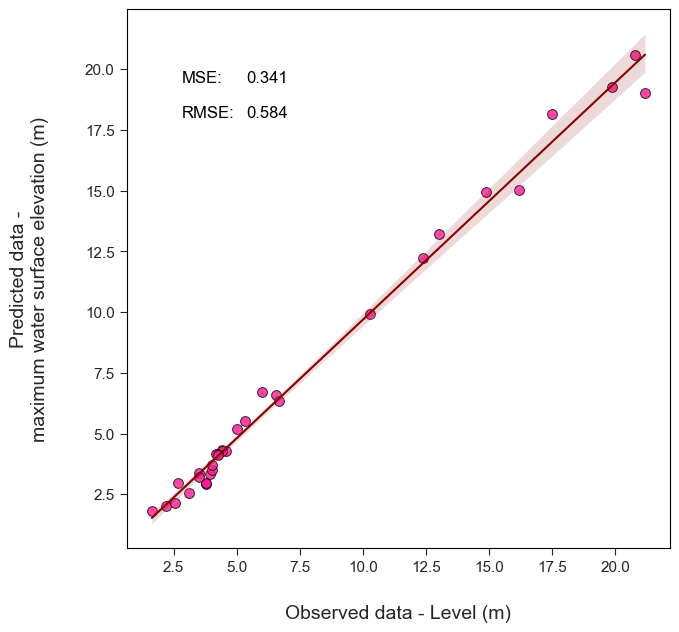

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(7, 7))

# Size for title and label
fontsize = 14
labelpad = 21

# Plot
sns.regplot(x='level', y='mxe', data=validation_df,
            scatter_kws={"s": 50, 'edgecolor': 'black', 'color':'deeppink', 'linewidth':.7},
            line_kws={'color':'darkred', 'linewidth':1.5}, marker='o', ci=95, ax=ax)

# Adjust x and y labels
ax.set_xlabel("Observed data - Level (m)", fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel("Predicted data -\nmaximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

# Set up ticks
ax.set_yticks(np.arange(2.5, 21, 2.5))

# For frame
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
# Set up ticks
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-3)
ax.tick_params(direction='out', length=5, pad=labelpad-17)
    

title_error = "MSE:\n\nRMSE:"
error = f"{validation_mxe_mse:.3f}\n\n{validation_mxe_rmse:.3f}"

# Error added into the text
# Ref: https://github.com/matplotlib/matplotlib/issues/253/
#      https://stackoverflow.com/questions/67366092/valueerror-alignment-not-allowed-in-string-format-specifier-sometimes-not
#      https://stackoverflow.com/questions/8234445/format-output-string-right-alignment
ax.text(
    .1, .8, # Control the text on the x axis and y axis
    title_error,
    size=fontsize-2, ha='left', color='black', transform=ax.transAxes
)
ax.text(
    .22, .8, # Control the text on the x axis and y axis
    error,
    size=fontsize-2, ha='left', color='black', transform=ax.transAxes
)

plt.savefig(fr"{main_dir}\validation_result.png", bbox_inches='tight', dpi=330)

---------------------------------------------------------------------

## CALIBRATION

#### 1. Get data

In [14]:
# Get range of calibration
n_calibration = np.round(np.arange(0.5, 2.6, 0.1), 1)

In [15]:
%%time
# Get dictionary of calibration results
n_dict = get_dict('mxe', n_calibration, 'out.mxe', debris_df)

CPU times: total: 8.02 s
Wall time: 9.94 s


#### 2. Counting NaNs

In [16]:
# Copy dictionary
import copy
n_dict_copy_001 = copy.deepcopy(n_dict)

In [17]:
# Counting NaNs
num_missing_values = []
for i in range(len(n_calibration)):
    nan_num = n_dict_copy_001[f"n_{n_calibration[i]}"].mxe.isna().sum()
    text = "n = {0} has {1} missing values".format(n_calibration[i], nan_num)
    num_missing_values.append(nan_num)
    print(text)

n = 0.5 has 18 missing values
n = 0.6 has 15 missing values
n = 0.7 has 14 missing values
n = 0.8 has 13 missing values
n = 0.9 has 10 missing values
n = 1.0 has 10 missing values
n = 1.1 has 9 missing values
n = 1.2 has 8 missing values
n = 1.3 has 8 missing values
n = 1.4 has 6 missing values
n = 1.5 has 5 missing values
n = 1.6 has 3 missing values
n = 1.7 has 2 missing values
n = 1.8 has 2 missing values
n = 1.9 has 2 missing values
n = 2.0 has 2 missing values
n = 2.1 has 2 missing values
n = 2.2 has 2 missing values
n = 2.3 has 2 missing values
n = 2.4 has 2 missing values
n = 2.5 has 2 missing values


Text(0, 0.5, 'Missing values')

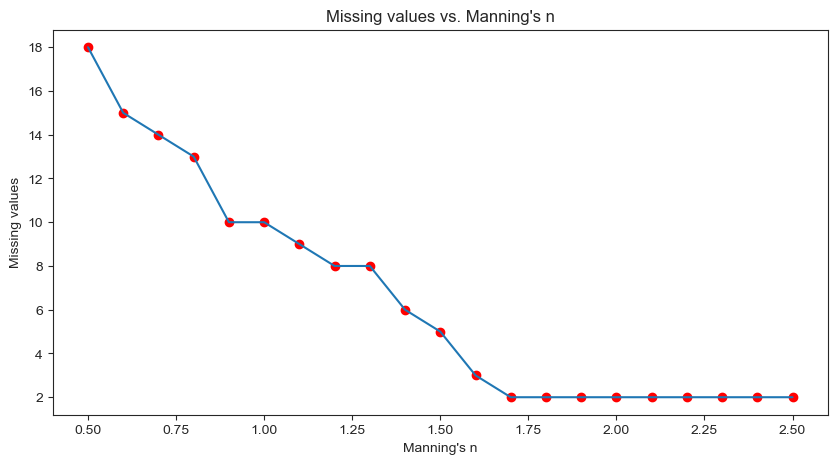

In [18]:
# Plot missing values
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(x=n_calibration, y=num_missing_values, c='red')
ax.plot(n_calibration, num_missing_values) # For line
ax.set_title("Missing values vs. Manning's n")
ax.set_xlabel("Manning's n")
ax.set_ylabel("Missing values")

#### 3. Get errors

In [19]:
# Copy dictionary
n_dict_copy_002 = copy.deepcopy(n_dict)

In [20]:
# Get no missing data dictionary
n_nomissing_dict = {}
for i in range(len(n_calibration)):
    n_nomissing_dict[f"n_{n_calibration[i]}"] = n_dict_copy_002[f"n_{n_calibration[i]}"][n_dict_copy_002['n_0.5'].mxe.notnull()]

In [21]:
# Generate RMSE without missing values
rmse_selectedmissing_list = []
for i in range(len(n_calibration)):
    rmse = mean_squared_error(
        n_nomissing_dict[f"n_{n_calibration[i]}"][n_nomissing_dict[f"n_{n_calibration[i]}"].mxe.notnull()].level, 
        n_nomissing_dict[f"n_{n_calibration[i]}"][n_nomissing_dict[f"n_{n_calibration[i]}"].mxe.notnull()].mxe, 
        squared=False
    )
    rmse_selectedmissing_list.append(rmse)
    text = "RMSE when n = {0} is {1:.3f}".format(n_calibration[i], rmse_selectedmissing_list[i])
    print(text)

RMSE when n = 0.5 is 0.924
RMSE when n = 0.6 is 0.783
RMSE when n = 0.7 is 0.670
RMSE when n = 0.8 is 0.581
RMSE when n = 0.9 is 0.514
RMSE when n = 1.0 is 0.467
RMSE when n = 1.1 is 0.440
RMSE when n = 1.2 is 0.431
RMSE when n = 1.3 is 0.439
RMSE when n = 1.4 is 0.457
RMSE when n = 1.5 is 0.484
RMSE when n = 1.6 is 0.511
RMSE when n = 1.7 is 0.538
RMSE when n = 1.8 is 0.564
RMSE when n = 1.9 is 0.590
RMSE when n = 2.0 is 0.615
RMSE when n = 2.1 is 0.638
RMSE when n = 2.2 is 0.661
RMSE when n = 2.3 is 0.685
RMSE when n = 2.4 is 0.710
RMSE when n = 2.5 is 0.738


In [22]:
# # Connected line
# fig, ax = plt.subplots(figsize=(16, 6))

# fontsize = 15
# labelpad = 21

# # Plot
# # Line
# ax.plot(n_calibration, rmse_selectedmissing_list, c='deeppink') # For line
# # Points
# ax.scatter(x=n_calibration, y=rmse_selectedmissing_list, 
#            facecolor='maroon', edgecolor='white', linewidth=1, s=70, zorder=2)

# # Set up ticks
# ax.set_xticks(np.arange(.5, 2.6, .1))
# ax.set_yticks(np.arange(.3, 1, .1))

# # Set up x limit
# ax.set_ylim(bottom=.37)

# # Adjust x and y labels
# ax.set_xlabel("Multipliers of Manning's n", fontsize=fontsize, labelpad=labelpad)
# ax.set_ylabel("RMSE\nof maximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

    
# # Set up ticks
# for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
#     item.set_fontsize(fontsize-2)
# ax.tick_params(direction='out', length=labelpad-15, pad=labelpad-13)

# # Save
# plt.savefig(fr"{main_dir}\calibration_connectedline.png", bbox_inches='tight', dpi=330)

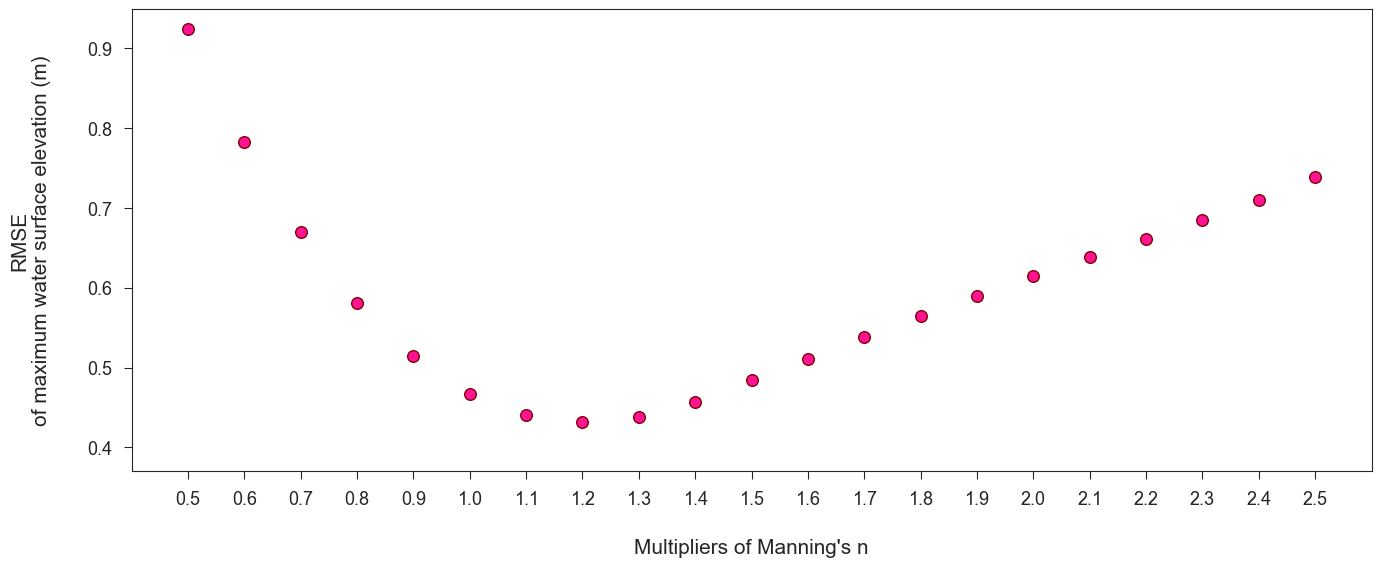

In [23]:
# No connected lines
fig, ax = plt.subplots(figsize=(16, 6))

fontsize = 15
labelpad = 21

# Plot
ax.scatter(x=n_calibration, y=rmse_selectedmissing_list, 
           facecolor='deeppink', edgecolor='maroon', linewidth=1, s=70, zorder=2)

# Set up ticks
ax.set_xticks(np.arange(.5, 2.6, .1))
ax.set_yticks(np.arange(.3, 1, .1))

# Set up x limit
ax.set_ylim(bottom=.37)

# Adjust x and y labels
ax.set_xlabel("Multipliers of Manning's n", fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel("RMSE\nof maximum water surface elevation (m)", rotation=-270, fontsize=fontsize, labelpad=labelpad+5)

    
# Set up ticks
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-2)
ax.tick_params(direction='out', length=labelpad-15, pad=labelpad-13)

# Save
plt.savefig(fr"{main_dir}\calibration_noconnectedline.png", bbox_inches='tight', dpi=330)